In [1]:
import torch
# print(torch.__version__)
!pip install torch==1.12.1
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu102.html
!pip install torch-geometric
!pip install optuna
# print(torch.__version__)
# I ran this on Collab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
print(os.listdir())
os.chdir("sample_data")

['.config', 'sample_data', 'drive']


In [4]:

# !unzip ../drive/MyDrive/"Skripsi (1)"/Face.zip

In [5]:
os.chdir("GCN")

In [6]:
import optuna
from transformer import GNN
from dataload import load_data

from focal_loss import FocalLoss
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score,classification_report
from tqdm import tqdm
import pandas as pd
from torch_geometric.data import DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


device(type='cuda', index=0)

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [8]:

def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for _, batch in enumerate((train_loader)):
        # Use GPU
        batch.to(device)  
        # Reset gradients
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred = model(batch.x.float(), 
                                batch.edge_attr.float(),
                                batch.edge_index,
                                batch.batch) 
        # print(pred,batch.y-1)
        # Calculating the loss and gradients
        # print(pred,batch.y)
        loss = loss_fn(pred, batch.y)
        loss.backward()  
        optimizer.step()  
        # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(torch.argmax(pred, dim=1).cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    
    return (running_loss/step),all_preds,all_labels


In [9]:

def test(epoch, model, test_loader, loss_fn):
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for batch in test_loader:
        batch.to(device)  
        pred = model(batch.x.float(), 
                        batch.edge_attr.float(),
                        batch.edge_index,
                        batch.batch) 
        
        loss = loss_fn(pred, batch.y)
        # print(torch.argmax(pred, dim=1).cpu().detach().numpy())
        # print(batch.y)
         # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(torch.argmax(pred, dim=1).cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())
    # flatten
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()

    # calculate_metrics(all_preds, all_labels, "test")
    
    return (running_loss/step),all_preds,all_labels

In [10]:
import seaborn as sns

def calculate_metrics(y_pred, y_true,status = "Train"):
    
    # print(f"\n Confusion matrix {status}: \n {confusion_matrix(y_pred, y_true)}")
    data = confusion_matrix(y_pred, y_true)
    df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'


    # f, ax = plt.subplots(figsize=(5, 5))
    # cmap = sns.cubehelix_palette(light=1, as_cmap=True)

    # sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
    #             annot_kws={'size': 10})
    # plt.title('Actuals vs Predicted')
    # plt.show()
    # print(f"Accuracy {status} : {accuracy_score(y_true, y_pred)}")

    a = [y_true,y_pred]
    return a

In [11]:
def my_plot(epochs, loss,title,flag = "train"):
    if flag == "train":    
     
      plt.plot(epochs, loss,label=flag,color='green',linestyle='dashed')
      plt.xlabel('Epoch') 
      plt.ylabel('Loss') 
      plt.title("Train "+title)
      plt.show()
    else:
     
      plt.plot(epochs, loss,label=flag,color='red')
      plt.xlabel('Epoch') 
      plt.ylabel('Accuracy') 
      plt.title("Test "+title)
      plt.show()



  
# displaying the title

  


In [12]:
def plot_akhir_loss(epoch,loss_train,loss_val):
  epochs = range(0,epoch)
  print("losss")
  print(loss_train[epoch-1])
  print(loss_val[epoch-1])
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='Testing loss')
  plt.title('Training and Testing loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_akhir_acc(epoch,acc_train,acc_test):
  epochs = range(0,epoch)
  print("Auc")
  print(acc_train[epoch-1])
  print(acc_test[epoch-1])
  plt.plot(epochs, acc_train, 'g', label='Training Accuracy')
  plt.plot(epochs, acc_test, 'b', label='Testing Accuracy')
  plt.title('Training and Testing Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [13]:
def accuracy(pred,target):
  return accuracy_score(target, pred)

In [14]:
from sklearn.model_selection import KFold
import time
def run_one_training(params,dataset):
   
    print("**********************")
    print("Trial with: ", params)

    results = {}
    # Cross validation 5 splits
    kfold = KFold(n_splits=5,shuffle=True,random_state = 42)
    train_loss_final=[]
    test_loss_final=[]
    train_acc_final=[]
    test_acc_final=[]
    training_time=[]
    hasil = 0
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        # print('--------------------------------')
        # print(f'FOLD {fold}')
        # print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        
        train_loader = DataLoader(dataset, batch_size=params["batch_size"],sampler=train_subsampler)
        test_loader = DataLoader(dataset, batch_size=params["batch_size"], sampler=test_subsampler)

        # for step, data in enumerate(train_loader):
        #     print(f'Step loader{step + 1}:')
        #     print('=======')
        #     print(f'Number of graphs in the current batch: {data.num_graphs}')
        #     print(data)
        #     print()
      
        params["model_edge_dim"] = dataset[0].edge_attr.shape[1]
        # Loading the model
        # print("Loading model...")
        model_params = {k: v for k, v in params.items() if k.startswith("model_")}
        model = GNN(feature_size=dataset[0].x.shape[1], model_params=model_params) 
        model = model.to(device)
        # print(model)
        # print(f"Number of parameters: {count_parameters(model)}")
    
        # < 1 increases precision, > 1 recall
        weight = torch.tensor([1.0635, 2.3929, 0.7976, 1.9143, 0.6837, 1.5952, 0.5630], dtype=torch.float32).to(device)
        # pos_weight=weight
        loss_fn = FocalLoss()  
        # loss_fn = torch.nn.CrossEntropyLoss(weight=weight)
        # optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        optimizer = getattr(torch.optim, params['optimizer'])(model.parameters(), lr= params['learning_rate'],
                                                              weight_decay=params["weight_decay"])
        # optimizer = torch.optim.Adam(model.parameters(), 
        #                             lr=params["learning_rate"],
        #                             # momentum=params["sgd_momentum"],
        #                             )
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params["scheduler_gamma"])
    
        # Start training
        best_loss = 1000
        early_stopping_counter = 0
        loss_vals=[]
        loss_train = []
        acc_train = []
        acc_vals= []
        epoch_now = 0
        epoch_now_test = 0
        epoch_loss = 0
        total_time = 0
        for epoch in range(30): 
            
            # if early_stopping_counter <= 10: 
                # Training
            t0 = time.time()
            model.train()
            train_loss,pred_train,target_train = train_one_epoch(epoch, model, train_loader, optimizer, loss_fn)
            loss_train.append(train_loss)
            # calculate_metrics(pred_train, target_train,"Train")
            acc_train.append(accuracy(pred_train,target_train))
            # print(f"Epoch {epoch} | Train Loss {train_loss}")
            spending_time = (time.time() - t0)
            # print('{} seconds'.format(spending_time))
            total_time+=spending_time
            # print("================================================")
            

            # Testing
            model.eval()
            
            test_loss,pred_test,target_test = test(epoch, model, test_loader, loss_fn)
            loss_vals.append(test_loss)
            # calculate_metrics(pred_test, target_test,"Test")
            acc_vals.append(accuracy(pred_test,target_test))
            # print(f"Epoch {epoch} | Test Loss {test_loss}")
            
            # Update best loss
            if float(test_loss) < best_loss:
                best_loss = test_loss
                # Save the currently best model 
                
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            epoch_now_test +=1

            scheduler.step()
            epoch_now= epoch+1      
            # else:
            #     print("Early stopping due to no improvement.")
                # my_plot(np.linspace(1, epoch_now, epoch_now).astype(int), loss_vals)
                

                      
            # print(f"Finishing training with best test loss: {best_loss}")
            # my_plot(np.linspace(1, epoch_now, epoch_now).astype(int), loss_vals)
        results[fold] = calculate_metrics(pred_test,target_test,"FOLD")
        # print("Total time= ",(total_time / 30))
        training_time.append((total_time / 30))
        # Print fold results
        # print(f'K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS')
        # print('--------------------------------')
        sum = 0.0
        labels = ["anger","contempt", "disgust", "fear", "happy", "sadness","surprise"]
        sum_accuracy = 0
        sum_prec = 0
        sum_rec =0

        for key, value in results.items():
            print(f'Fold {key}')
            # print(f"Accuracy: {accuracy_score(value[0], value[1])}")
            acc  = accuracy_score(value[0], value[1])
            prec = precision_score(value[0], value[1],average = None)
            rec = recall_score(value[0], value[1],average = None)
            # print("Precision: ",prec)
            # print("Recall: ",rec)
            # print(f"\n Confusion matrix fold: \n {confusion_matrix(value[0], value[1])}")
            # print()
            sum_accuracy += acc
            sum_prec += prec
            sum_rec += rec
            # print("Classification Report")
            target_names =['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness','surprise']
            # print(classification_report(value[0],value[1],target_names=target_names))
        # print("================================================")
        # print(f'Average Accuracy: {sum_accuracy/len(results.items())} %')
        hasil=(sum_accuracy/len(results.items()))
        # print(f'Average Precision: {sum_prec/len(results.items())} %')
        # print(f'Average Recall: {sum_rec/len(results.items())} %')
        # print("Plotting")
        # my_plot(np.linspace(1, epoch_now, epoch_now).astype(int), loss_train,"Loss","train")
        # my_plot(np.linspace(1, epoch_now_test, epoch_now_test).astype(int), loss_vals,"Loss","test")
        # my_plot(np.linspace(1, epoch_now, epoch_now).astype(int), acc_train,"Accuracy","train")
        # my_plot(np.linspace(1, epoch_now_test, epoch_now_test).astype(int), acc_vals,"Accuracy","test")
        train_loss_final.append(loss_train)
        test_loss_final.append(loss_vals)
        train_acc_final.append(acc_train)
        test_acc_final.append(acc_vals)
        
      # plottinf fold
    # print("*=*=*=*=*=*=*=*=*=*=*=*=*=*=*")
    # for i in range(len(training_time)):
    #   print("Fold ke = ",i+1)
    #   print(training_time[i])

    # torch.save(model.state_dict(),"../../../drive/MyDrive/Skripsi (1)/GCN_Proposed_Method.pt")
    # Loss_train
    # print(train_loss_final)
    data_loss_train = np.array(train_loss_final)
    # print(data_loss_train.shape)
    avg_loss_train = np.average(data_loss_train, axis=0)
  
    # loss test
    data_loss_test = np.array(test_loss_final)
    avg_loss_test = np.average(data_loss_test, axis=0)
    # Accuracy train
    data_acc_train = np.array(train_acc_final)
    avg_acc_train = np.average(data_acc_train, axis=0)
    # Accuracy test
    data_acc_test = np.array(test_acc_final)
    avg_acc_test = np.average(data_acc_test, axis=0)
    # plotting
    print("Plotting akhir")
    plot_akhir_loss(30,avg_loss_train,avg_loss_test)
    plot_akhir_acc(30,avg_acc_train,avg_acc_test)
    print("=============================")
    return hasil

In [15]:
os.chdir("Dataset")

!ls 

test_delaunay  train_delaunay


In [16]:
torch.cuda.empty_cache() 
import gc
# del variables
# gc.collect()
# print(torch.cuda.memory_summary(device=None, abbreviated=False))


In [17]:
# !pip install optuna

In [18]:
train_dataset,test_dataset = load_data()
dataset = train_dataset + test_dataset

# def objective(trial):
#   BEST_PARAMETERS = {
#     "batch_size": trial.suggest_int("batch_size",32,128),
#     "learning_rate": trial.suggest_float('learning_rate',0.001,0.1),
#     "weight_decay": trial.suggest_float('weight_decay',5e-4,0.1),
#     "scheduler_gamma":trial.suggest_float("scheduler_gamma",0.001, 0.9),
#     "model_layers_size":trial.suggest_int('layers_size',1,8),
#     "model_embedding_size": trial.suggest_int("model_embedding_size",16,128),
#     'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
#     "model_dropout_rate": trial.suggest_float("model_dropout_rate",0.2,0.8),
#     "model_dense_neurons": trial.suggest_int("model_dense_neurons",216,4096)
#   }
#   global dataset
#   print("Dataaset:",len(dataset))
#   return run_one_training(BEST_PARAMETERS,dataset)



TRAIN IDX:  0
TRAIN IDX:  50
TRAIN IDX:  100
TRAIN IDX:  150
TRAIN IDX:  200
TRAIN IDX:  250
TEST IDX:  0
TEST IDX:  50


In [19]:
# import warnings
# warnings.filterwarnings('ignore')
# study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
# study.optimize(objective, n_trials=30)

In [20]:
# best_trial = study.best_trial

# for key, value in best_trial.params.items():
#     print("{}: {}".format(key, value))
# print(study.best_trial.value)

In [21]:
# optuna.visualization.plot_optimization_history(study)

In [22]:

# optuna.visualization.plot_param_importances(study)

In [23]:
parameters = {
    
"batch_size": 64,
"learning_rate": 0.0017482176977940307,
"weight_decay": 0.01294674779434874,
"scheduler_gamma": 0.8042648633451702,
"model_layers_size": 4,
"model_embedding_size": 91,
"optimizer": "Adam",
"model_dropout_rate": 0.5062707436806835,
"model_dense_neurons": 3612,

}


**********************
Trial with:  {'batch_size': 64, 'learning_rate': 0.0017482176977940307, 'weight_decay': 0.01294674779434874, 'scheduler_gamma': 0.8042648633451702, 'model_layers_size': 4, 'model_embedding_size': 91, 'optimizer': 'Adam', 'model_dropout_rate': 0.5062707436806835, 'model_dense_neurons': 3612}
Fold 0
Fold 0
Fold 1
Fold 0
Fold 1
Fold 2
Fold 0
Fold 1
Fold 2
Fold 3
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Plotting akhir
losss
0.0051882199851596466
0.024805240728892387


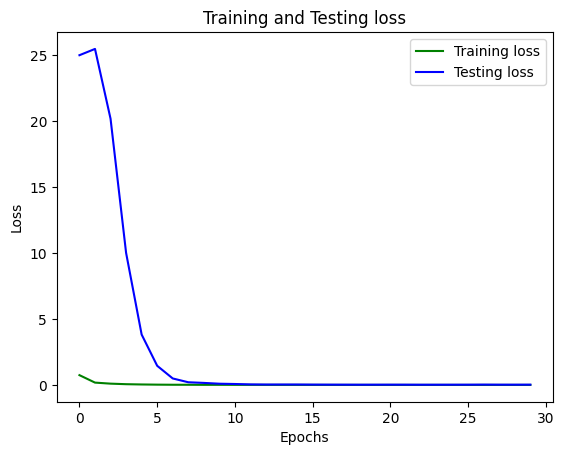

Auc
0.9527999897973499
0.9114875056051526


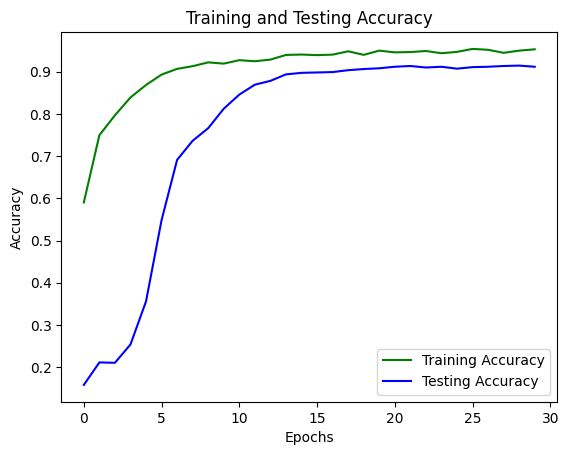

0.9114875056051526


In [24]:
import warnings
warnings.filterwarnings('ignore')
a= run_one_training(parameters,dataset)
print(a)